<a href="https://colab.research.google.com/github/codesanya/dobbe-xray-preprocessing/blob/main/notebooks/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
data_path = '/content/drive/MyDrive/Images_Data_science_intern'
print(os.listdir(data_path))  # Should list your .dcm, .rvg files


['IS20250116_180218_7445_56958340.dcm', 'R9.rvg', 'R5.rvg', 'IS20250115_190348_9148_86297118.dcm', 'R6.rvg', 'R10.rvg', 'R7.rvg', 'IS20250115_171841_9465_61003253.dcm', 'IS20250218_193552_3393_78829426.dcm', 'R4.rvg', 'IS20250115_191316_7227_10120577.dcm', 'IS20250221_192657_5718_56712676.dcm', 'Reference_Output_Quality.jpg', 'IS20250218_193621_8940_10081171.dcm']


In [3]:
# Clone your GitHub repo into Colab
!git clone https://github.com/codesanya/dobbe-xray-preprocessing.git
%cd dobbe-xray-preprocessing


Cloning into 'dobbe-xray-preprocessing'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 2), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), done.
Resolving deltas: 100% (2/2), done.
/content/dobbe-xray-preprocessing


In [5]:
!pip install pydicom opencv-python-headless scikit-image matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.2 MB/s eta 0:00:00


In [6]:
# List the structure
!apt-get install tree
!tree -L 2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (85.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
.
├── notebooks
│   └── code.ipynb
├── README.md
├── results
└── src
    ├── dicom_reader.py
    └── preprocessing.py

3 directories, 4 files


In [7]:

all_files = os.listdir(data_path)
dcm_files = [f for f in all_files if f.endswith('.dcm')]
rvg_files = [f for f in all_files if f.endswith('.rvg')]
reference_image = [f for f in all_files if f.endswith('.jpg')][0]  # Assuming one JPG

print("DICOM files:", dcm_files)
print("RVG files:", rvg_files)
print("Reference image:", reference_image)



DICOM files: ['IS20250116_180218_7445_56958340.dcm', 'IS20250115_190348_9148_86297118.dcm', 'IS20250115_171841_9465_61003253.dcm', 'IS20250218_193552_3393_78829426.dcm', 'IS20250115_191316_7227_10120577.dcm', 'IS20250221_192657_5718_56712676.dcm', 'IS20250218_193621_8940_10081171.dcm']
RVG files: ['R9.rvg', 'R5.rvg', 'R6.rvg', 'R10.rvg', 'R7.rvg', 'R4.rvg']
Reference image: Reference_Output_Quality.jpg


In [9]:
import pydicom
import matplotlib.pyplot as plt



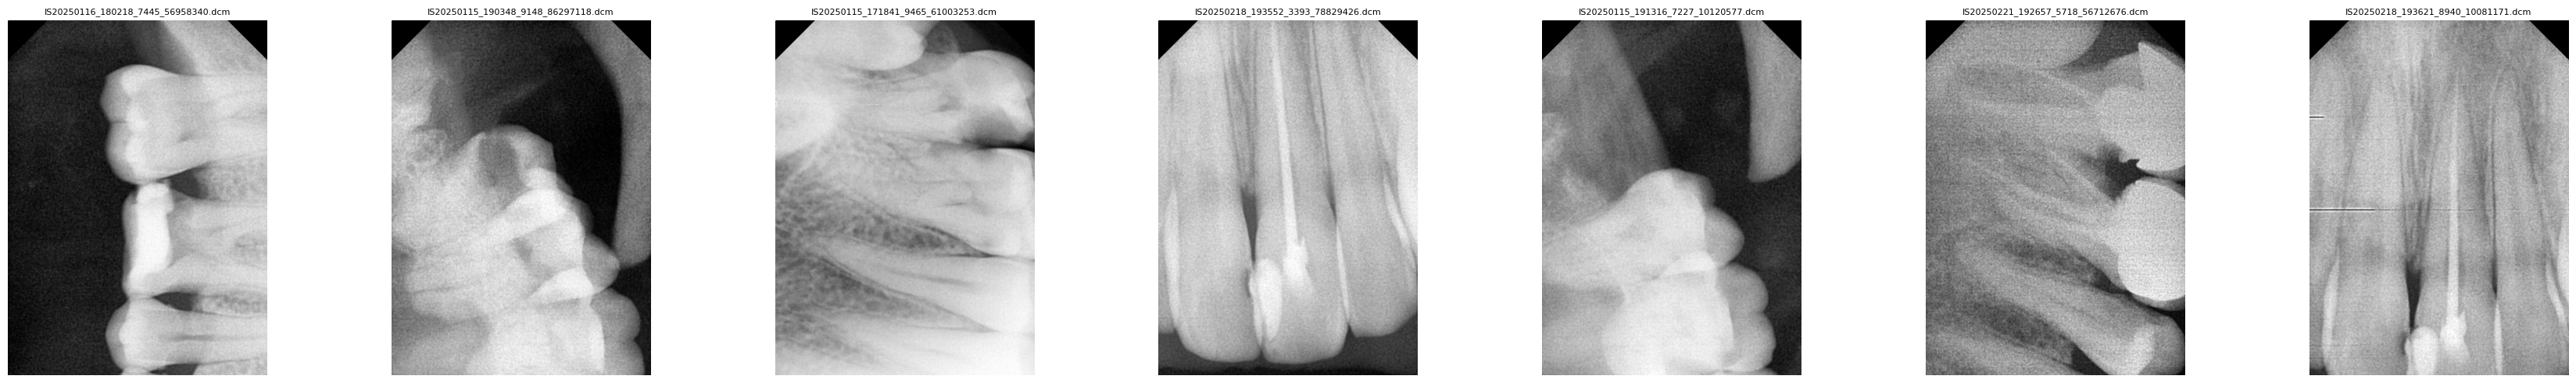

In [12]:
# Set up subplot
fig, axes = plt.subplots(1, len(dcm_files), figsize=(5 * len(dcm_files), 5))

# If only one image, make axes a list
if len(dcm_files) == 1:
    axes = [axes]

# Plot each image
for ax, file in zip(axes, dcm_files):
    file_path = os.path.join(data_path, file)
    dicom_data = pydicom.dcmread(file_path)
    ax.imshow(dicom_data.pixel_array, cmap="gray")
    ax.set_title(file, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [21]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

def brightness(img):
    return np.mean(img)

def contrast_std(img):
    return np.std(img)

def contrast_rms(img):
    return np.sqrt(np.mean((img - np.mean(img))**2))

def contrast_michelson(img):
    return (np.max(img) - np.min(img)) / (np.max(img) + np.min(img))

def sharpness_laplacian(img):
    lap = cv2.Laplacian(img, cv2.CV_64F)
    return lap.var()

def sharpness_tenengrad(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    fm = gx**2 + gy**2
    return np.mean(fm)

def noise_wavelet(img):
    # Wavelet decomposition and estimate noise from detail coefficients
    coeffs = pywt.wavedec2(img, 'db1', level=1)
    # Detail coefficients at level 1
    cH, cV, cD = coeffs[-1]
    # Estimate noise sigma using Median Absolute Deviation
    sigma_est = np.median(np.abs(cD)) / 0.6745
    return sigma_est


In [22]:
import pydicom
import os
import pandas as pd

image_info = []

for file in dcm_files:
    file_path = os.path.join(data_path, file)
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # Normalize to 0-255

    image_info.append({
        "filename": file,
        "brightness": brightness(img_norm),
        "contrast_std": contrast_std(img_norm),
        "contrast_rms": contrast_rms(img_norm),
        "contrast_michelson": contrast_michelson(img_norm),
        "sharpness_laplacian": sharpness_laplacian(img_norm),
        "sharpness_tenengrad": sharpness_tenengrad(img_norm),
        "noise_wavelet": noise_wavelet(img_norm)
    })

df_metrics = pd.DataFrame(image_info)
print(df_metrics)


                              filename  brightness  contrast_std  \
0  IS20250116_180218_7445_56958340.dcm  116.353666     83.571523   
1  IS20250115_190348_9148_86297118.dcm  130.841968     76.732539   
2  IS20250115_171841_9465_61003253.dcm  174.680312     49.159848   
3  IS20250218_193552_3393_78829426.dcm  175.434204     50.173657   
4  IS20250115_191316_7227_10120577.dcm  127.776491     72.300866   
5  IS20250221_192657_5718_56712676.dcm  142.199735     43.952417   
6  IS20250218_193621_8940_10081171.dcm  166.896803     34.428060   

   contrast_rms  contrast_michelson  sharpness_laplacian  sharpness_tenengrad  \
0     83.571523                 1.0            89.436735          1171.726664   
1     76.732539                 1.0           116.697883          1383.181292   
2     49.159848                 1.0            82.741920           730.633011   
3     50.173657                 1.0           175.698120          1658.815142   
4     72.300866                 1.0           101.

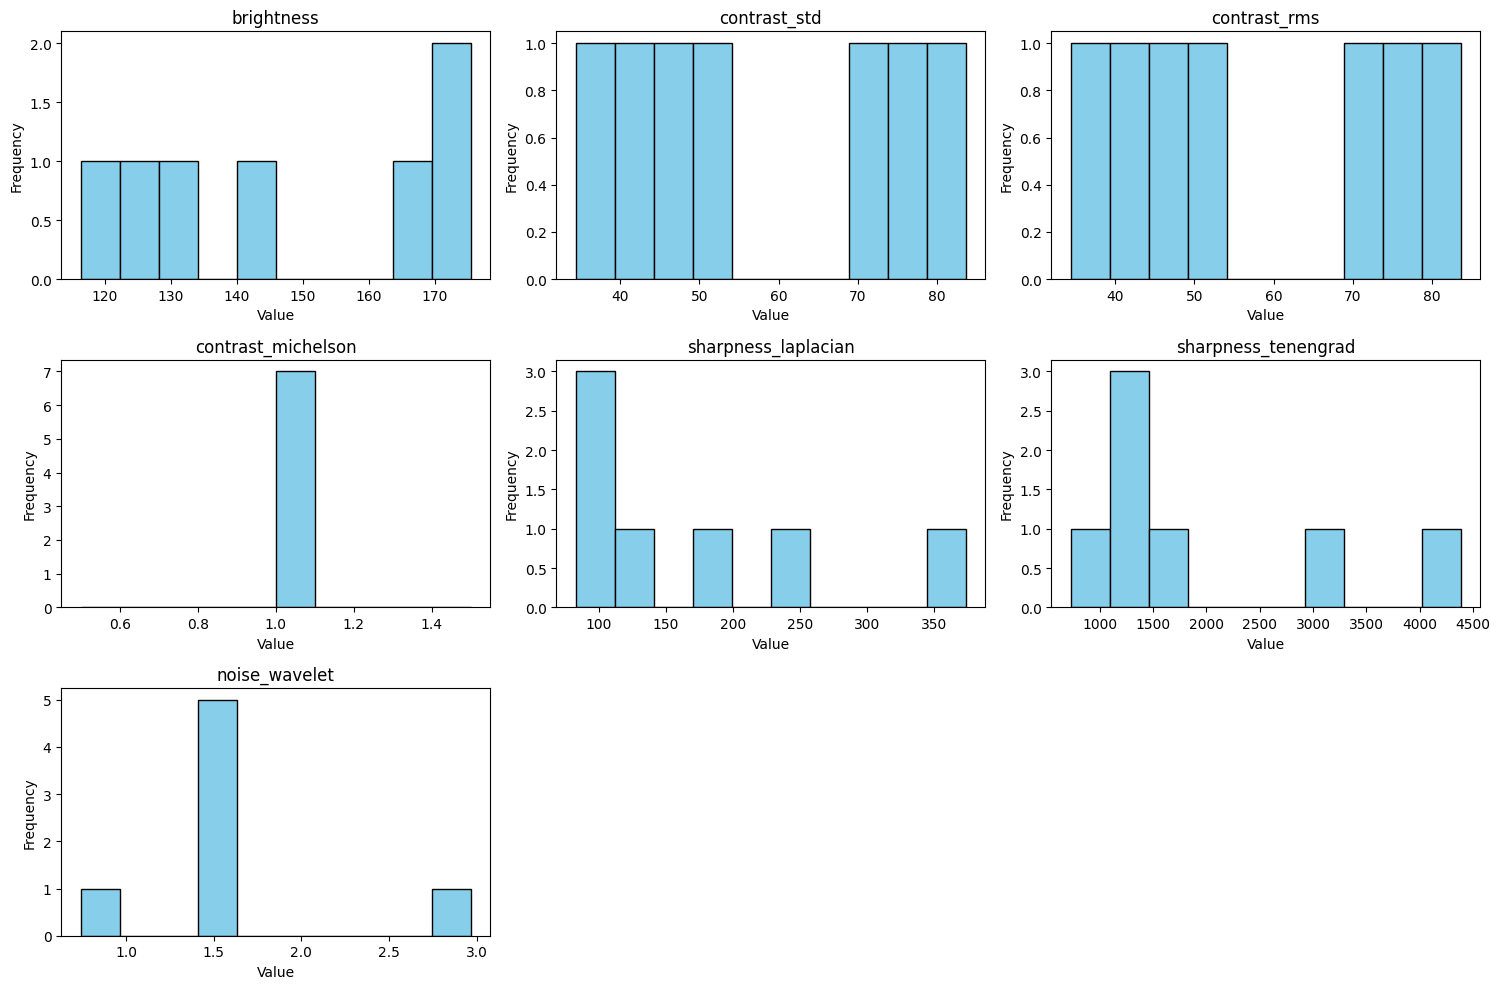

In [23]:
metrics = ["brightness", "contrast_std", "contrast_rms", "contrast_michelson",
           "sharpness_laplacian", "sharpness_tenengrad", "noise_wavelet"]

plt.figure(figsize=(15,10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    plt.hist(df_metrics[metric], bins=10, color='skyblue', edgecolor='black')
    plt.title(metric)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


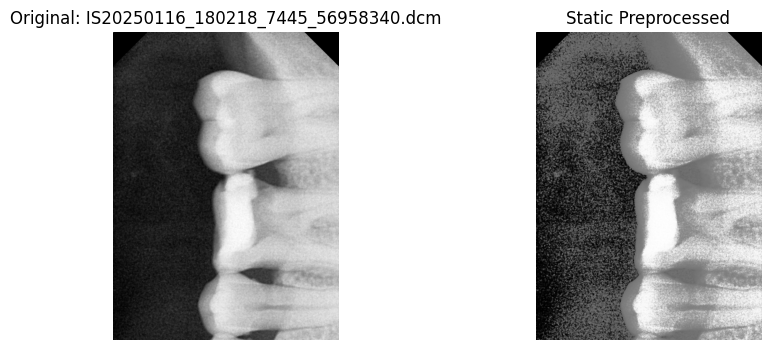

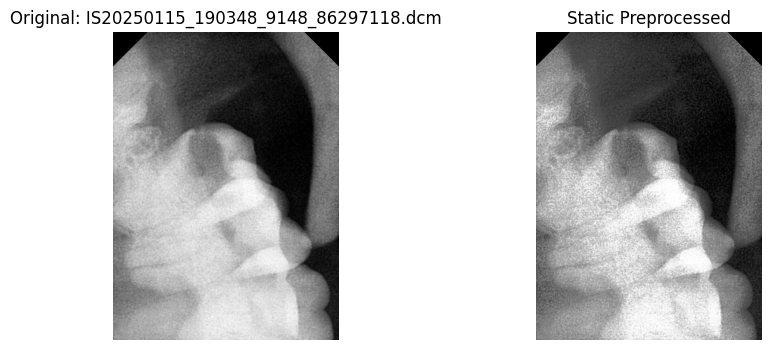

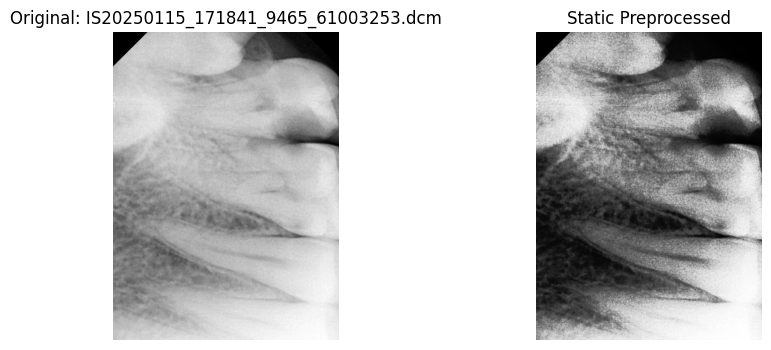

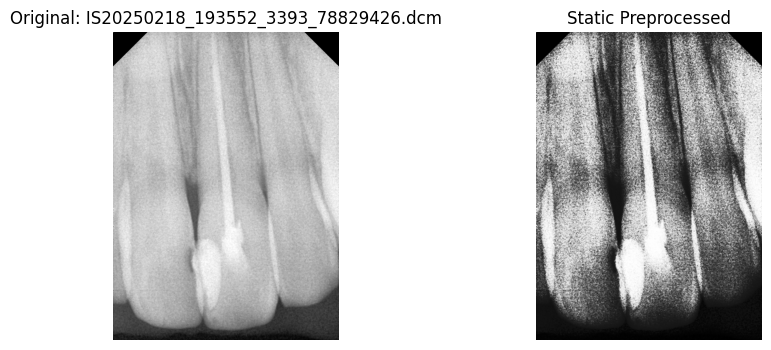

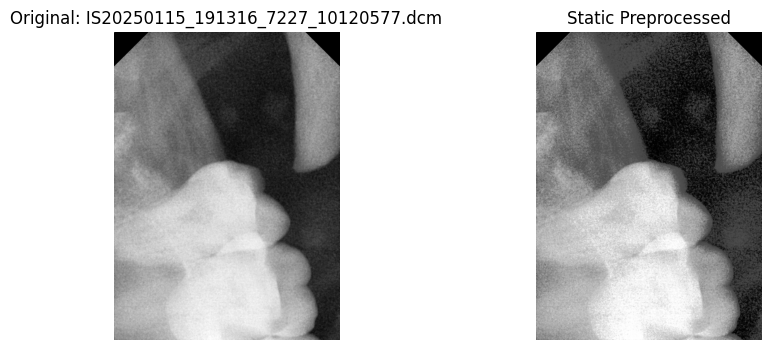

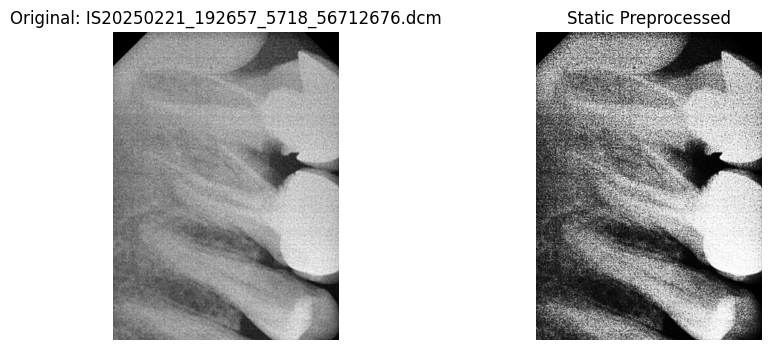

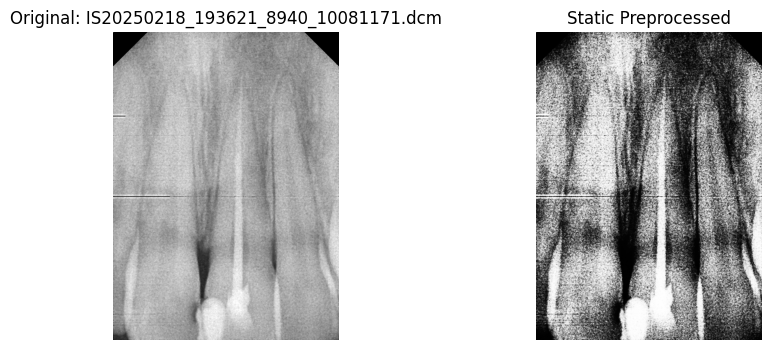

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os

def static_preprocess(image):
    # Histogram Equalization
    img_eq = cv2.equalizeHist(image)
    # Sharpening filter
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    img_sharp = cv2.filter2D(img_eq, -1, kernel_sharpening)
    # Gaussian blur denoising
    img_denoised = cv2.GaussianBlur(img_sharp, (3,3), 0)
    return img_denoised

for file in dcm_files:
    file_path = os.path.join(data_path, file)
    ds = pydicom.dcmread(file_path)
    image = ds.pixel_array.astype(np.uint8)

    processed_img = static_preprocess(image)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original: {file}')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed_img, cmap='gray')
    plt.title('Static Preprocessed')
    plt.axis('off')

    plt.show()


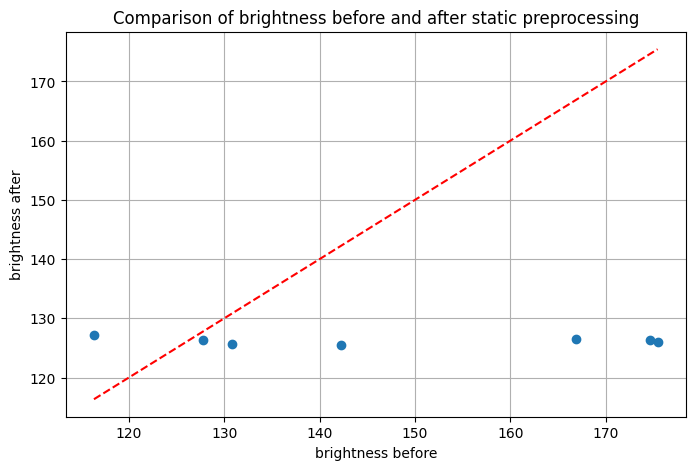

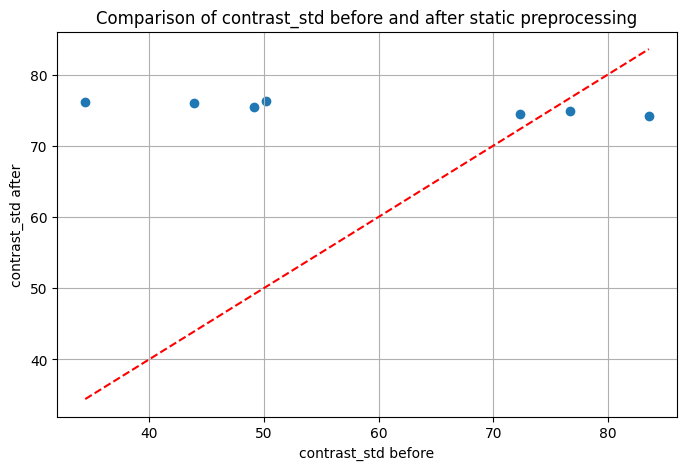

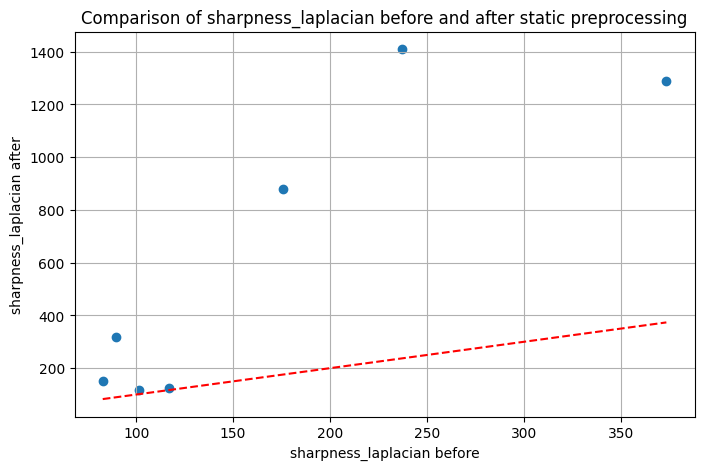

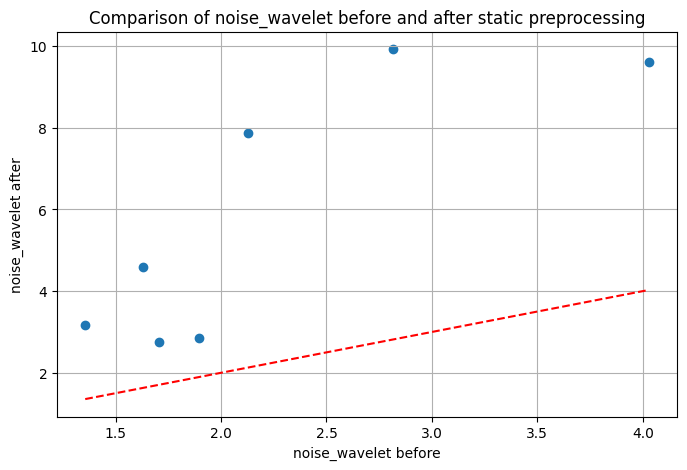

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os

# Static pipeline function
def static_preprocess(image):
    img_eq = cv2.equalizeHist(image)
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    img_sharp = cv2.filter2D(img_eq, -1, kernel_sharpening)
    img_denoised = cv2.GaussianBlur(img_sharp, (3,3), 0)
    return img_denoised

# Functions to calculate metrics
def calc_brightness(img):
    return np.mean(img)

def calc_contrast_std(img):
    return np.std(img)

def calc_sharpness_laplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

def calc_noise_wavelet(img):
    # Simple noise estimate: stddev of difference between image and median filtered image
    median = cv2.medianBlur(img, 3)
    noise = img.astype(np.float32) - median.astype(np.float32)
    return np.std(noise)

# Store metrics
metrics_before = []
metrics_after = []

for file in dcm_files:
    file_path = os.path.join(data_path, file)
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.uint8)

    processed = static_preprocess(img)

    # Before metrics
    b_before = calc_brightness(img)
    c_before = calc_contrast_std(img)
    s_before = calc_sharpness_laplacian(img)
    n_before = calc_noise_wavelet(img)

    # After metrics
    b_after = calc_brightness(processed)
    c_after = calc_contrast_std(processed)
    s_after = calc_sharpness_laplacian(processed)
    n_after = calc_noise_wavelet(processed)

    metrics_before.append([file, b_before, c_before, s_before, n_before])
    metrics_after.append([file, b_after, c_after, s_after, n_after])

# Convert to DataFrames
import pandas as pd

df_before = pd.DataFrame(metrics_before, columns=['filename', 'brightness', 'contrast_std', 'sharpness_laplacian', 'noise_wavelet'])
df_after = pd.DataFrame(metrics_after, columns=['filename', 'brightness', 'contrast_std', 'sharpness_laplacian', 'noise_wavelet'])

# Merge on filename for easy comparison
df_compare = df_before.merge(df_after, on='filename', suffixes=('_before', '_after'))

# Plot comparison for each metric
metrics = ['brightness', 'contrast_std', 'sharpness_laplacian', 'noise_wavelet']

for metric in metrics:
    plt.figure(figsize=(8,5))
    plt.scatter(df_compare[f'{metric}_before'], df_compare[f'{metric}_after'])
    plt.plot([df_compare[f'{metric}_before'].min(), df_compare[f'{metric}_before'].max()],
             [df_compare[f'{metric}_before'].min(), df_compare[f'{metric}_before'].max()], 'r--')
    plt.xlabel(f'{metric} before')
    plt.ylabel(f'{metric} after')
    plt.title(f'Comparison of {metric} before and after static preprocessing')
    plt.grid(True)
    plt.show()

# Show some images where metric decreased (example for sharpness)
worse_sharpness = df_compare[df_compare['sharpness_laplacian_after'] < df_compare['sharpness_laplacian_before']]

for idx, row in worse_sharpness.head(3).iterrows():
    file_path = os.path.join(data_path, row['filename'])
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.uint8)
    processed = static_preprocess(img)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original: {row["filename"]}')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed, cmap='gray')
    plt.title('Processed (Sharpness ↓)')
    plt.axis('off')

    plt.show()
